In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import mlflow
import mlflow.pytorch
import wandb
import os
from dotenv import load_dotenv

In [2]:
import ale_py
gym.register_envs(ale_py)

In [3]:
class ConvDQN(nn.Module):
    def __init__(self, input_channels, action_size):
        super(ConvDQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Calculate correct feature size dynamically
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        """Calculate the output size of conv layers"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)  # 2 channels, 84x84
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)  # Flatten size per sample
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done
    
    def __len__(self):
        return len(self.buffer)

def preprocess_frame(frame):
    import cv2
    gray = np.mean(frame, axis=2).astype(np.uint8)
    cropped = gray[34:194, :]
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

class FrameStack:
    def __init__(self, num_frames=2):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        return np.stack(list(self.frames), axis=0)

In [4]:
def train_dqn():
    # Load environment variables for wandb
    load_dotenv('/home/bmartins/dev/rl_study/.env')
    wandb_key = os.getenv('WANDB_KEY')
    
    # Initialize wandb
    wandb.login(key=wandb_key)
    wandb.init(
        project="pong-dqn-training",
        name="pong_cnn_dqn",
        config={
            "learning_rate": 0.0001,
            "gamma": 0.99,
            "epsilon_start": 1.0,
            "epsilon_min": 0.01,
            "epsilon_decay": 0.995,
            "batch_size": 32,
            "buffer_size": 100000,
            "target_update": 1000,
            "mean_reward_bound": 19.5,
            "frame_skip": 4,
            "architecture": "CNN-DQN",
            "input_channels": 2,
            "frame_stack": 2
        }
    )
    
    # MLflow experiment setup
    mlflow.set_experiment("Pong_CNN_DQN_Training")
    
    with mlflow.start_run():
        # Create artifacts directory using MLflow run ID
        run_id = mlflow.active_run().info.run_id
        artifacts_dir = f"/home/bmartins/dev/rl_study/artifacts/run_{run_id}"
        os.makedirs(artifacts_dir, exist_ok=True)
        print(f"Artifacts will be saved to: {artifacts_dir}")
        
        env = gym.make('PongNoFrameskip-v4')
        
        # Hyperparameters
        action_size = env.action_space.n
        lr = 0.0001
        gamma = 0.99
        epsilon = 1.0
        epsilon_min = 0.01
        epsilon_decay = 0.995
        batch_size = 32
        buffer_size = 100000
        target_update = 1000
        mean_reward_bound = 19.5
        frame_skip = 4
        
        # Log hyperparameters to MLflow
        mlflow.log_params({
            "learning_rate": lr,
            "gamma": gamma,
            "epsilon_start": epsilon,
            "epsilon_min": epsilon_min,
            "epsilon_decay": epsilon_decay,
            "batch_size": batch_size,
            "buffer_size": buffer_size,
            "target_update": target_update,
            "mean_reward_bound": mean_reward_bound,
            "frame_skip": frame_skip,
            "artifacts_dir": artifacts_dir
        })
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        mlflow.log_param("device", str(device))
        
        main_net = ConvDQN(input_channels=2, action_size=action_size).to(device)
        target_net = ConvDQN(input_channels=2, action_size=action_size).to(device)
        target_net.load_state_dict(main_net.state_dict())
        
        # Log model info
        total_params = sum(p.numel() for p in main_net.parameters())
        mlflow.log_param("total_parameters", total_params)
        wandb.log({"total_parameters": total_params})
        
        optimizer = optim.Adam(main_net.parameters(), lr=lr)
        buffer = ReplayBuffer(buffer_size)
        
        episode_rewards = []
        mean_rewards = []
        episode = 0
        
        while True:
            state, _ = env.reset()
            frame_stack = FrameStack(2)
            stacked_state = frame_stack.reset(state)
            total_reward = 0
            done = False
            step_count = 0
            
            while not done:
                if random.random() > epsilon:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(stacked_state).unsqueeze(0).to(device)
                        q_values = main_net(state_tensor)
                        action = q_values.max(1)[1].item()
                else:
                    action = env.action_space.sample()
                
                step_reward = 0
                for _ in range(frame_skip):
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    step_reward += reward
                    if terminated or truncated:
                        break
                
                done = terminated or truncated
                next_stacked_state = frame_stack.step(next_state)
                
                buffer.push(stacked_state, action, step_reward, next_stacked_state, done)
                stacked_state = next_stacked_state
                total_reward += step_reward
                step_count += 1
                
                if len(buffer) > batch_size:
                    states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                    
                    states = torch.FloatTensor(states).to(device)
                    actions = torch.LongTensor(actions).to(device)
                    rewards = torch.FloatTensor(rewards).to(device)
                    next_states = torch.FloatTensor(next_states).to(device)
                    dones = torch.BoolTensor(dones).to(device)
                    
                    current_q_values = main_net(states).gather(1, actions.unsqueeze(1))
                    
                    with torch.no_grad():
                        next_q_values = target_net(next_states).max(1)[0]
                        target_q_values = rewards + (gamma * next_q_values * ~dones)
                    
                    loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(main_net.parameters(), max_norm=10)
                    optimizer.step()
                    
                    # Log loss every 1000 steps
                    if step_count % 1000 == 0:
                        mlflow.log_metric("loss", loss.item(), step=episode * 10000 + step_count)
                        wandb.log({"loss": loss.item(), "step": episode * 10000 + step_count})
            
            if episode % target_update == 0:
                target_net.load_state_dict(main_net.state_dict())
            
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            episode_rewards.append(total_reward)
            mean_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            
            # Log episode metrics to both MLflow and wandb
            metrics = {
                "episode_reward": total_reward,
                "mean_reward_100": mean_reward,
                "epsilon": epsilon,
                "buffer_size": len(buffer),
                "episode_length": step_count,
                "episode": episode
            }
            
            mlflow.log_metrics({
                "episode_reward": total_reward,
                "mean_reward_100": mean_reward,
                "epsilon": epsilon,
                "buffer_size": len(buffer),
                "episode_length": step_count
            }, step=episode)
            
            wandb.log(metrics)
            
            if mean_reward >= mean_reward_bound:
                print(f"Environment solved in {episode} episodes with mean reward: {mean_reward:.2f}")
                mlflow.log_metric("solved_at_episode", episode)
                wandb.log({"solved_at_episode": episode})
                break
            
            # Save checkpoint every 10000 episodes
            if episode > 0 and episode % 10000 == 0:
                checkpoint_path = os.path.join(artifacts_dir, f'pong_dqn_cnn_checkpoint_ep{episode}.pth')
                torch.save({
                    'episode': episode,
                    'model_state_dict': main_net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'avg_reward': np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards),
                    'epsilon': epsilon,
                    'episode_rewards': episode_rewards,
                    'run_id': run_id
                }, checkpoint_path)
                
                # Log checkpoint to MLflow and wandb
                mlflow.log_artifact(checkpoint_path)
                wandb.save(checkpoint_path)
                print(f"Checkpoint saved at episode {episode}: {checkpoint_path}")
                
                # Save plot to file every 10000 episodes
                if len(episode_rewards) > 1:
                    # Calculate mean rewards for plotting (using 10-episode averages)
                    plot_episodes = []
                    plot_rewards = []
                    for i in range(10, len(episode_rewards) + 1, 10):
                        plot_episodes.append(i)
                        plot_rewards.append(np.mean(episode_rewards[i-10:i]))
                    
                    plt.figure(figsize=(12, 5))
                    
                    plt.subplot(1, 2, 1)
                    plt.plot(plot_episodes, plot_rewards, 'b-', linewidth=2, marker='o')
                    plt.title('CNN-DQN Pong Training Progress')
                    plt.xlabel('Episode')
                    plt.ylabel('Mean Reward (last 10 episodes)')
                    plt.grid(True, alpha=0.3)
                    plt.axhline(y=mean_reward_bound, color='r', linestyle='--', label=f'Target ({mean_reward_bound})')
                    plt.legend()
                    
                    plt.subplot(1, 2, 2)
                    plt.plot(range(len(plot_rewards)), plot_rewards, 'g-', linewidth=2)
                    plt.title('Training Progress Detail')
                    plt.xlabel('Episodes (x10)')
                    plt.ylabel('Average Reward')
                    plt.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    
                    # Save plot to file
                    plot_path = os.path.join(artifacts_dir, f"cnn_training_plot_ep{episode}.png")
                    plt.savefig(plot_path)
                    mlflow.log_artifact(plot_path)
                    wandb.log({"training_plot": wandb.Image(plot_path)})
                    plt.close()  # Close to save memory
                    
                    print(f"Plot saved at episode {episode}: {plot_path}")
            
            # Display plot to screen every 100 episodes
            if episode % 100 == 0 and episode > 0:
                avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                mean_rewards.append(avg_reward)
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}, Buffer: {len(buffer)}")
                
                # Display plot to screen
                if len(episode_rewards) > 1:
                    # Calculate mean rewards for plotting (using 10-episode averages)
                    plot_episodes = []
                    plot_rewards = []
                    for i in range(10, len(episode_rewards) + 1, 10):
                        plot_episodes.append(i)
                        plot_rewards.append(np.mean(episode_rewards[i-10:i]))
                    
                    clear_output(wait=True)
                    plt.figure(figsize=(12, 5))
                    
                    plt.subplot(1, 2, 1)
                    plt.plot(plot_episodes, plot_rewards, 'b-', linewidth=2, marker='o')
                    plt.title('CNN-DQN Pong Training Progress')
                    plt.xlabel('Episode')
                    plt.ylabel('Mean Reward (last 10 episodes)')
                    plt.grid(True, alpha=0.3)
                    plt.axhline(y=mean_reward_bound, color='r', linestyle='--', label=f'Target ({mean_reward_bound})')
                    plt.legend()
                    
                    plt.subplot(1, 2, 2)
                    plt.plot(range(len(plot_rewards)), plot_rewards, 'g-', linewidth=2)
                    plt.title('Training Progress Detail')
                    plt.xlabel('Episodes (x10)')
                    plt.ylabel('Average Reward')
                    plt.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
            
            # Print progress every 10 episodes (no plotting)
            elif episode % 10 == 0 and episode > 0:
                avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
                print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}, Buffer: {len(buffer)}")
                
                # Log 10-episode average
                mlflow.log_metric("avg_reward_10", avg_reward, step=episode)
                wandb.log({"avg_reward_10": avg_reward})

            episode += 1
        
        # Log final model
        mlflow.pytorch.log_model(main_net, "final_model")
        
        # Log final metrics
        final_metrics = {
            "final_episode": episode,
            "final_mean_reward": mean_reward,
            "total_episodes": len(episode_rewards)
        }
        
        mlflow.log_metrics(final_metrics)
        wandb.log(final_metrics)
        
        # Save final model to wandb (in run-specific folder)
        final_model_path = os.path.join(artifacts_dir, 'final_pong_dqn_cnn_model.pth')
        torch.save({
            'model_state_dict': main_net.state_dict(),
            'run_id': run_id,
            'final_metrics': final_metrics
        }, final_model_path)
        wandb.save(final_model_path)
        
        print(f"Training completed! All artifacts saved in: {artifacts_dir}")
        
        env.close()
        wandb.finish()
        return main_net

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# Test CNN architecture
env = gym.make('PongNoFrameskip-v4')
state, _ = env.reset()

print(f"Original frame shape: {state.shape}")

processed = preprocess_frame(state)
print(f"Processed frame shape: {processed.shape}")

frame_stack = FrameStack(2)
stacked = frame_stack.reset(state)
print(f"Stacked frames shape: {stacked.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_net = ConvDQN(input_channels=2, action_size=env.action_space.n).to(device)

with torch.no_grad():
    state_tensor = torch.FloatTensor(stacked).unsqueeze(0).to(device)
    q_values = cnn_net(state_tensor)
    print(f"Network input shape: {state_tensor.shape}")
    print(f"Q-values shape: {q_values.shape}")
    print(f"Q-values: {q_values.cpu().numpy()}")

total_params = sum(p.numel() for p in cnn_net.parameters())
print(f"\nTotal parameters: {total_params:,}")

env.close()

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Original frame shape: (210, 160, 3)
Processed frame shape: (84, 84)
Stacked frames shape: (2, 84, 84)
Network input shape: torch.Size([1, 2, 84, 84])
Q-values shape: torch.Size([1, 6])
Q-values: [[-0.02384317  0.03587015 -0.03555597  0.0160556   0.04009825 -0.00618187]]

Total parameters: 3,354,278


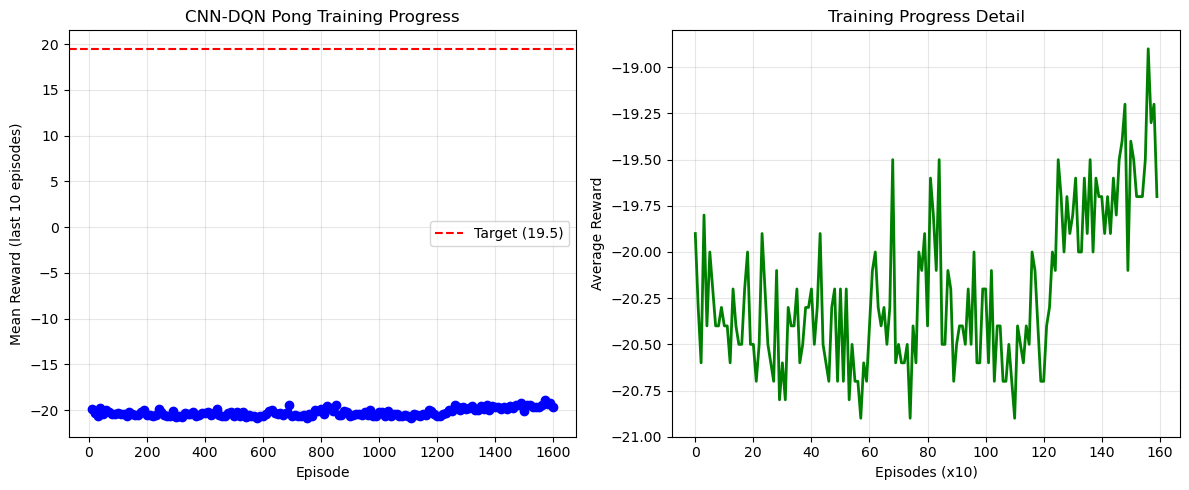

Episode 1610, Avg Reward: -19.90, Epsilon: 0.010, Buffer: 100000
Episode 1620, Avg Reward: -19.10, Epsilon: 0.010, Buffer: 100000
Episode 1630, Avg Reward: -19.20, Epsilon: 0.010, Buffer: 100000
Episode 1640, Avg Reward: -19.20, Epsilon: 0.010, Buffer: 100000
Episode 1650, Avg Reward: -19.80, Epsilon: 0.010, Buffer: 100000
Episode 1660, Avg Reward: -19.40, Epsilon: 0.010, Buffer: 100000
Episode 1670, Avg Reward: -19.50, Epsilon: 0.010, Buffer: 100000
Episode 1680, Avg Reward: -20.30, Epsilon: 0.010, Buffer: 100000


In [ ]:
# Train the CNN-based DQN
trained_model = train_dqn()
print("CNN-DQN Training completed!")